-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [19]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

In [121]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [16]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.normal(0.5,0,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0.5,0,(self.N,1))
        self.v = np.random.normal(0.5,0,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [17]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))

    # forward propagation
    def predict(self, x, w, b, v):
        
        a = np.dot(w, x) - b
        z = self.g(a)
        self.output = np.dot(v, z)
        return self.output
    
    """
    there's a mistake here somewhere... 
    
    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        a = np.dot(w, self.X) - b
        f_x = self.predict(self.X, w, b, v)
        
        dw = 2*self.rho*w + (1/self.X.shape[1]) * ((v.T @ (f_x-self.y)) * self.g_der(a)) @ X_train.T
        db = 2*self.rho*b + (1/self.X.shape[1]) * (v.T @ (f_x-self.y)) * self.g_der(a)
        db = np.sum(db, axis = 1, keepdims = True)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(a).T

        return np.concatenate([array.reshape(-1) for array in [dw, db, dv]])
    """
    
    
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        
        """
        to use the manual gradient put jac = self.grad and check if train error is still 0.001392
        """
        result =  minimize(self.loss, x0 = inits, method = self.method)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        self.w, self.b, self.v = self.separate(result.x)
        
        func_eval = result.nfev
        grad_eval = result.njev
        iterations = result.nit
        opt_fun = result.fun
        return func_eval, grad_eval, iterations, opt_fun, time_elapsed

## first run

In [18]:
nn = Mlp(X_train, y_train, N = 20, sigma = 2, rho = 10e-5, method = "BFGS")
func_eval, grad_eval, iterations, opt_fun, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))

begin training... 

      fun: 0.01137583587596467
 hess_inv: array([[ 232.98822275, -283.21181602,  -24.60007904, ...,   -6.76046927,
         -18.77230739,   93.39312649],
       [-283.21181602,  957.22091887,   33.45958088, ...,   49.09528787,
          68.4649472 ,  -79.1730364 ],
       [ -24.60007904,   33.45958088,  237.94528146, ...,   36.54592092,
         -41.91508666, -134.45551595],
       ...,
       [  -6.76046927,   49.09528787,   36.54592092, ...,  851.12731956,
        -110.3904556 , -134.38391598],
       [ -18.77230739,   68.4649472 ,  -41.91508666, ..., -110.3904556 ,
         849.33509216,   63.46119349],
       [  93.39312649,  -79.1730364 , -134.45551595, ..., -134.38391598,
          63.46119349,  711.11174225]])
      jac: array([ 7.67712481e-06, -1.30885746e-06,  9.40228347e-06, -7.80215487e-07,
        4.53391112e-06,  4.83123586e-08,  2.58698128e-06,  2.21841037e-06,
        4.99410089e-06, -6.70435838e-07,  5.41831832e-06, -4.72064130e-07,
        4.2871106

In [447]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(1, -1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    


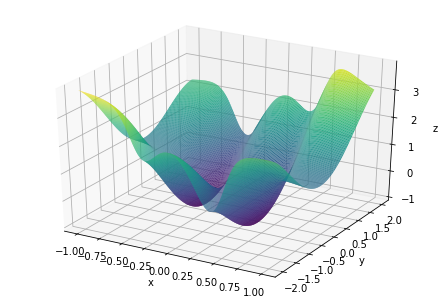

In [40]:
plot(nn)

In [239]:
#
# Grid Search (takes ~2 hours) -------> (50, 5, 0.0001, 'CG') error on val of ~0.00022
#

"""
param_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    print("current combination :", comb)
    print("\n")
    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))
"""

'\nparam_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}\n\nresults = []\ncombinations = list(itertools.product(*param_grid.values()))\nfor comb in tqdm_notebook(combinations):\n    \n    print("current combination :", comb)\n    print("\n")\n    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])\n    nn.optimize()\n    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))\n'

In [218]:
# trials for the graddient....
N = 20
w = np.random.uniform(0,1,(N, 2))
b = np.random.normal(0,1,(N, 1))
v = np.random.normal(0,1,(1, N))
# activation function
def g(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x)) 
def sech(x):
    return np.square(2/(np.exp(x) - np.exp(-x)))
    
a = np.dot(w, X_train) - b
z = g(a)
f_x = np.dot(v, z)
rho = 10e-5

dw = (1/X_train.shape[1]) * (v.T @ (f_x-y_train) * (1-np.square(g(a)))) @ X_train.T
#dw = 2*rho*np.sum(w) + (1/X_train.shape[1]) * np.dot(np.dot(v.T, f_x-y_train)* (1-np.square(g(a))), X_train.T)
dv = 2*rho*v + (1/X_train.shape[1]) * np.dot(f_x-y_train, g(a).T)
db = 2*rho*b + (1/X_train.shape[1]) * np.dot(v.T, f_x-y_train)* np.square(sech(a))
db = np.sum(db, axis = 1, keepdims = True)
#boh2 = 2*rho*v + np.mean((f_x - y_train) * g(a))

In [28]:
print(dw)

[[-1.28284973 -0.32930668]
 [-2.99232749 -0.5261328 ]
 [ 0.09353115  0.02782646]
 [-0.47702474 -0.12077391]
 [ 0.02765735  0.00555457]
 [ 0.03497815  0.00643308]
 [-3.4025571  -0.65848697]
 [ 5.53015046  0.91638261]
 [ 0.18201416 -0.0315615 ]
 [-0.45496767 -0.17485321]
 [ 2.20109846  0.46887725]
 [-1.30413367 -0.8536718 ]
 [-1.08864446 -0.28585821]
 [-0.89955819 -0.64727476]
 [-0.64758837 -0.10023912]
 [ 0.51038744  0.0807671 ]
 [ 1.18513171 -0.12911536]
 [-0.4856348  -0.29706555]
 [-0.38704297 -0.22881224]
 [ 1.52739735  0.31245266]]


In [19]:
2*rho*np.sum(w) + (1/X_train.shape[1]) * np.dot(np.dot(v.T, f_x-y_train)* (1-np.square(g(a))), X_train.T)

array([[-0.36416989,  0.32642425],
       [-0.04616261, -0.20215945],
       [-0.15864655,  0.26325293],
       [ 0.60101376, -0.51211595],
       [ 0.1338876 , -0.03095073],
       [-0.46385986,  1.00930537],
       [ 1.28953353, -0.87882896],
       [-0.55839382,  0.3873266 ],
       [ 0.16834935,  0.48005134],
       [ 0.00773789, -0.06199074],
       [-1.2615162 ,  0.81552151],
       [-1.43321644,  0.83663871],
       [-0.1553988 ,  0.05481721],
       [ 0.33063404, -0.4147983 ],
       [ 0.81149272, -0.33949117],
       [-0.22334479,  0.40873182],
       [-0.13268599, -0.20464219],
       [-1.12255175,  0.40842122],
       [-1.01868065,  0.43970415],
       [-0.63191294,  0.47555013]])

In [15]:
v = (y_train.dot(a.T.dot(a) + rho*np.identity(X_train.shape[1]))).dot(a.T)

In [113]:
np.concatenate((z.T, rho*np.identity(N))).shape

(230, 20)

In [115]:
np.concatenate((y_train, np.zeros(20)))

array([ 1.30859380e+00,  2.56154100e+00,  7.79290010e-01,  1.14841914e+00,
        2.10916347e+00,  2.89578397e+00, -3.27758446e-03,  2.42421913e+00,
        6.91687817e-01,  2.09507280e+00, -4.81234602e-01,  1.76638091e+00,
        4.36194418e-01,  1.91900767e+00,  2.33155807e+00,  2.68338499e-01,
       -7.38349856e-01,  3.09578433e+00,  2.60239393e-01,  1.68262452e+00,
        2.17437668e+00, -4.02127143e-01,  1.29418040e-01,  1.29847979e+00,
        1.24588148e+00,  4.02259673e-01,  2.40535396e+00,  4.72370948e+00,
        1.31003176e+00, -4.27831556e-01,  2.24280527e+00,  1.18329221e+00,
        2.12794540e+00,  2.11069093e+00,  1.38541858e+00, -8.92896333e-01,
        2.72092285e+00, -6.35756190e-03,  2.31350881e+00,  8.84595386e-01,
        5.82505414e-01,  1.51404648e+00,  1.40850994e+00,  2.41108402e+00,
        6.93412176e-01,  6.67446325e-01,  1.64918509e+00,  5.35551969e-01,
        2.17221095e+00,  6.43193105e-01,  3.62378234e+00,  3.66387571e-02,
        3.28705624e+00,  

------------------------------------

# Exercise 2.1

the error reduces to: $\underset{w_0, b_0, v}{min} \frac{1}{2P} (\sum_{p=1}^P v_j \sum_{i=1}^nw_{ij}x + b_j)- y^p)^2 + \rho||\mathbf{\omega}||^2 = ||\mathbf{v}(\mathbf{W}\mathbf{X} + \mathbf{b}) - \mathbf{Y}||^2 + \rho||\mathbf{v}||^2$



In [122]:
X_train, X_test, y_train, y_test = data_split(data, val = False)

In [544]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.uniform(-1,1,(self.N, self.X.shape[0]))
        self.b = np.random.uniform(-0.5,0.5,(self.N,1))
        self.v = np.zeros((1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) 
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

In [551]:
class Mlp_El(ShallowNeuralNetwork):

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))
    
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y))
    
    # forward propagation
    # to see why the mess here: https://stats.stackexchange.com/questions/69205/how-to-derive-the-ridge-regression-solution
    def optimize(self):
        
        a = self.w @ self.X - self.b
        H = self.g(a)
        H = np.concatenate((H.T, np.sqrt(self.rho)*np.identity(self.N))).T
        y = np.concatenate((self.y, np.zeros(self.N)))
        """
        clf = Ridge(alpha = self.rho, tol = 10e-8)
        print(H.shape, self.y.shape)
        clf.fit(H.T, self.y.T)
        self.v = clf.coef_
        """

        self.v =  np.linalg.inv(H @ H.T) @ H @ y # equal to self.v = y @ np.linalg.pinv(H) (moore-penrose pseudo inverse)
        
            
    # forward propagation
    def predict(self, x, w, b, v):
        
        a = w @ x - b
        z = self.g(a)
        self.output = v @ z
        return self.output

In [567]:
for i in range(200):
    nn = Mlp_El(X_train, y_train, N = 50, sigma = 5, rho = 10e-5)
    nn.optimize()
    concatenated = np.concatenate([array.reshape(-1) for array in [nn.w, nn.b, nn.v]])
    if np.linalg.norm(np.gradient(concatenated)) < 8:
        print("finished")
        break
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

finished


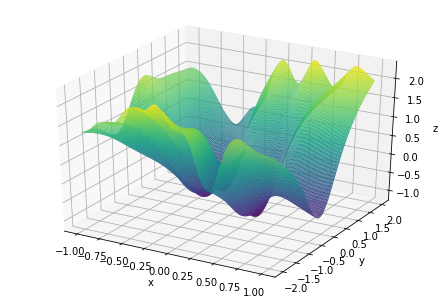

In [568]:
plot(nn)

----------------
## non exact el solution

In [545]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp_nonexact(ShallowNeuralNetwork):
    
    def loss(self,params):

        v = params
        return 0.5 * np.mean(np.square((self.predict(self.X, self.w, self.b, v) - self.y))) +\
        self.rho*np.square(np.linalg.norm(params))

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))

    # forward propagation
    def predict(self, x, w, b, v):
        
        a = np.dot(w, x) - b
        z = self.g(a)
        self.output = np.dot(v, z)
        return self.output
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = self.v
        
        print("begin training...", "\n")
        start = time.time()
 
        result =  minimize(self.loss, x0 = inits, method = self.method)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        self.v = result.x
        
        func_eval = result.nfev
        grad_eval = result.njev
        iterations = result.nit
        opt_fun = result.fun
        return func_eval, grad_eval, iterations, opt_fun, time_elapsed

In [548]:
nn = Mlp_nonexact(X_train, y_train, N = 50, sigma = 5, rho = 10e-5, method = "BFGS")
nn.optimize()
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

begin training... 

      fun: 0.21434232899242872
 hess_inv: array([[167.6306598 ,   0.73883963,  16.23774574, ...,   4.50678091,
         72.16952256, -31.0410441 ],
       [  0.73883963,  81.29433633,  17.40742103, ...,  -1.87214662,
         -8.64642784,  -3.76918385],
       [ 16.23774574,  17.40742103,  33.96765279, ...,  -5.31880458,
          3.73268064,  -3.71190205],
       ...,
       [  4.50678091,  -1.87214662,  -5.31880458, ...,  28.28395228,
        -32.33205274,   0.45650421],
       [ 72.16952256,  -8.64642784,   3.73268064, ..., -32.33205274,
        342.54354034, -42.34657529],
       [-31.0410441 ,  -3.76918385,  -3.71190205, ...,   0.45650421,
        -42.34657529,  96.5987029 ]])
      jac: array([-5.77419996e-08, -1.93901360e-06,  8.20308924e-06, -4.76278365e-06,
        4.34927642e-06, -1.27963722e-06, -2.60770321e-08,  1.16787851e-06,
       -2.30222940e-06,  1.00582838e-07,  1.21816993e-06, -2.80141830e-06,
        4.47779894e-06, -6.12810254e-06, -1.36718154e

In [549]:
np.linalg.norm(np.gradient(np.concatenate([array.reshape(-1) for array in [nn.w, nn.b, nn.v]])))

8.69313011610659

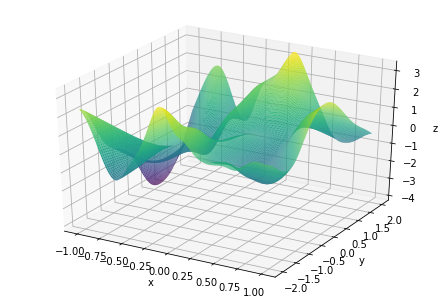

In [550]:
plot(nn)